Moving through the world depends on our ability to perceive and interpret visual information, with optic flow playing a crucial role. Optic flow provides essential cues for self-motion and navigation, helping us to determine our direction, speed and the structure of our environment. In particular, the radial pattern of motion we see as we move allows to atune our gaze with respect to our self motion. By targeting the focal point of expansion within this flow, we can accurately orient ourselves and adjust our trajectory. This will not only deepen our understanding of visual perception, but also highlight the practical importance of optic flow in everyday navigation, from avoiding obstacles to maintaining stability. 

In this notebook, we will generate a synthetic optic flow to challenge and examine how the visual system captures the focus of expansion. For this we will create a movie allowing to create an optic flow corresponding to moving inside a textured tunnel, potentially moving the center of the focus of expansion with respect to the center of gaze.

In [1]:
from IPython.display import Video
html_attributes = "loop=True autoplay=True  controls=True"
Video('../files/2025-04-24-orienting-yourself-in-the-visual-flow.mp4', html_attributes=html_attributes)

And try out how to move that FoE with respect to the center of gaze:

In [2]:
Video('../files/2025-04-24-orienting-yourself-in-the-visual-flow-perturb.mp4', html_attributes=html_attributes)

In [3]:
%pip install --upgrade pip
%pip  install torch==2.7.0





Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.



<!-- TEASER_END -->

Let's first initialize the notebook:

In [4]:
import os

import numpy as np
import torch
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)
import torch.nn.functional as F

import matplotlib.pyplot as plt

In [5]:
fig_width = 15
dpi = 'figure'
dpi = 200
opts_savefig = dict(dpi=dpi, bbox_inches='tight', pad_inches=0, edgecolor=None)



## creating an optic flow

Creating an optic flow can be straightforward using a procedural algorithm. This involves placing static visual objects, such as stars, within a 3D environment and then moving the camera (representing the viewer's perspective) through this space, for example, along a straight line. <nostalgia> Some of us may be reminded of looking endlessly to the screensavers in older computers with CRTs. </nostalgia>

See for instance https://github.com/NaturalPatterns/StarField for an easy way to generate such plots.


![alt text](https://raw.githubusercontent.com/NaturalPatterns/StarField/master/starfield.gif)

In this specific example, you observe that the motion of individual objects within the global optic flow converges on a single point, known as the focus of expansion (FoE). This convergence is a crucial emergent property of optic flow. We will explore manipulating scenarios where the FoE is not centrally located within the image. By doing so, we aim to simulate the perception of slightly sideways motion, which occurs when the direction of movement is not perfectly aligned with the center of the visual field. This approach will allow us to examine how the visual system adapts to and interprets off-center optic flow patterns.

To create a more natural and immersive optic flow, we will employ a different procedure that involves using a random texture mapped onto the surface of a cylinder. This approach simulates the visual experience of moving through a tunnel. The optic flow will be generated by simulating movement within this cylindrical environment, where the texture's perspective and motion dynamics mimic real-world visual cues. This method enhances the realism of the optic flow by providing a continuous and coherent visual field, allowing for a more authentic perception of self-motion.

![alt text](https://cdn.pixabay.com/photo/2013/03/16/01/30/cave-94193_1280.jpg)

This means we need to map the texture onto visual coordinates defined for a cylindrical surface. Given that we will perform transformations such as changing the view axis through simple translations later, we'll assume our gaze is aligned with the cylinder's axis. In a previous post, [Implementing a Retinotopic Transform Using grid_sample from PyTorch](https://laurentperrinet.github.io/sciblog/posts/2023-02-02-implementing-a-retinotopic-transform-using-grid_sample-from-pytorch.html), we modeled the retinotopic transform, which involves converting the visual field into retinotopic coordinates. This process is conceptually similar but in reverse. Therefore, we can leverage the same tools by designing new coordinates that accommodate the cylindrical mapping, ensuring a seamless and accurate transformation of the visual input. 


### definition of the grid

The texture will be mapped on the inner surface of the cylinder. One axis of the texture is thus the direction of each pixel with respect to the horizontal axis perpendicular to the optical / tunnel's axis. The second axis of the texture is along the depth, and will be repeated periodically with period $P$.

Let's define coordinates formally for a pinhole camera sitting at $F_C$ :

In [6]:
%%writefile /tmp/2025-04-24-orienting-yourself-in-the-visual-flow.tex
\documentclass[border=10pt,multi,tikz]{standalone}
\usepackage{tikz-3dplot}
\usetikzlibrary{calc,arrows.meta,positioning,backgrounds}
\begin{document}
\tdplotsetmaincoords{-60}{-35}
\begin{tikzpicture}
  [
    tdplot_main_coords,
    >=Stealth,
    my dashed/.style={dashed, thick, ->, shorten >=-15pt, shorten <=-15pt, every node/.append style={font=\footnotesize}},
    my box/.style={thin, gray!70},
    my blue/.style={blue, line cap=round, -{Triangle[width=3*#1]}, line width=#1, shorten >=#1*1.75pt, every node/.append style={fill, circle, inner sep=0pt, minimum size=#1*3.5pt, anchor=center, outer sep=0pt}},
    my label/.append style={midway, font=\scriptsize},
    my vectors/.style={green!50!black, {Stealth[scale=.75]}-{Stealth[scale=.75]}},
    my red/.style={thick, red, line cap=round},
    my grey/.style={gray!70},
    description/.style={draw=gray!70, thick, line cap=round, every node/.style={align=center, font=\scriptsize\sffamily, anchor=north}},
  ]
%   \draw [help lines] (-2,0,0) -- (2,0,0) node[anchor=north west]{$x$} (0,0,0) -- (0,7,0) node[anchor=north east]{$y$} (0,0,0) -- (0,0,2) node[anchor=north]{$z$} (-2,7,0) -- (2,7,0);
  \draw [my grey] (0,4,0) -- (0,7,0) (-2,7,0) -- (2,7,0);
  \coordinate (o) at (0,0,0);
  \path [draw=gray!70, text=gray, fill=gray!20, opacity=0.8, text opacity=1] (-1.5,4,1.75) coordinate (a) -- ++(0,0,-3.5) coordinate (b) -- ++(3,0,0) coordinate (c) -- ++(0,0,3.5) coordinate (d) -- cycle node [pos=.95, above, sloped, anchor=south west] {$z=f$} ;
%   \foreach \i in {a,b,c,d} \node [red, font=\scriptsize] at (\i) {\i};
  \draw [my grey] (-2,0,0) -- (2,0,0) (0,0,0) -- (0,4,0) (0,0,0) -- (0,0,2);
  \draw [thick, ->, every node/.style={font=\footnotesize, inner sep=0pt}] (o) node [anchor=north west] {$F_c$} (o) edge node [pos=1, anchor=north east] {$z_c$} ++(0,1,0) edge node [pos=1, anchor=north] {$y_c$} ++(0,0,1) -- ++(1,0,0) node [anchor=north west] {$x_c$};
  \draw [my box] (o) ++(0,4,-.5) coordinate (p1) -- ++(1,0,0) coordinate (p2) -- ++(0,0,-1.25) coordinate (p3);
  \foreach \i in {0,1,...,4} \draw [my box] (p1) ++(\i*.25,0,0) -- ++(0,0,-.25);
  \foreach \i in {0,1,...,5} \draw [my box] (p2) ++(0,0,-\i*.25) -- ++(-.25,0,0);
  \draw [my box] (p1) ++(0,0,-.25) -- ++(.75,0,0) -- ++(0,0,-1);
  \draw [my dashed, cyan] ($(b)!1/2!(c)$) -- ($(d)!1/2!(a)$) node [below=15pt, anchor=north] {$y$};
  \draw [my dashed, cyan] ($(b)!1/2!(a)$) -- ($(d)!1/2!(c)$) node [above right=17pt, anchor=north west] {$x$};
  \draw [my dashed, green!50!black, <->] (a) node [below=15pt, anchor=north] {$v$} -- (b) -- (c) node [above right=17pt, anchor=north west] {$u$};
  \path [green!50!black, every node/.style={font=\scriptsize, inner sep=0pt}] (p2) node [above right, anchor=south west] {$(u,v)$};
  \path (p2) ++(-.125,0,0) coordinate (q2) ++(0,0,-.125) coordinate (r2);
  \draw [my blue=1] ($(0,4,0)+($(q2)-(p1)$)$) coordinate (s2) -- (r2) node (d1) {};
  \scoped[on background layer]{\draw [my blue=1.75] ($($1.75*($(s2)-(0,4,0)$)$)+(0,7,0)$) -- ++($1.75*($(r2)-(s2)$)$) node (d2) [label={[label distance=-50pt]above:{$P=(R\cdot \cos\theta,R\cdot \sin\theta,Z)$}}] {};}
  \draw [my vectors] (0,4,.1) -- ($(s2)+(0,0,.1)$) node [below, my label, sloped] {$\vec{u}$};
  \draw [my vectors] (-.1,4,0) -- ($(q2)-(s2)+(-.1,4,0)$) node [left, my label] {$\vec{v}$};
  \draw [my red] (o) -- (d1.center);
  \scoped[on background layer]{\draw [my red] (d1.center) -- (d2.center);}
  \path [description] (0,4,0) [out=-95, in=95] to (-.75,4,.25) node {fixation\\point} (0,6.5,0) [out=-95, in=95] to (-.75,6.5,.25) node {optical\\axis};
\end{tikzpicture}
\end{document}

Overwriting /tmp/2025-04-24-orienting-yourself-in-the-visual-flow.tex


In [7]:
# !pdflatex -shell-escape -interaction=batchmode /tmp/2025-04-24-orienting-yourself-in-the-visual-flow.tex -output-directory=/tmp > /dev/null 2>&1
# !pdfcrop /tmp/2025-04-24-orienting-yourself-in-the-visual-flow.pdf /tmp/2025-04-24-orienting-yourself-in-the-visual-flow-crop.pdf > /dev/null 2>&1
# !magick  -density 200 -quality 100 /tmp/2025-04-24-orienting-yourself-in-the-visual-flow-crop.pdf -background white -flatten -alpha off ../files/2025-04-24-orienting-yourself-in-the-visual-flow.png

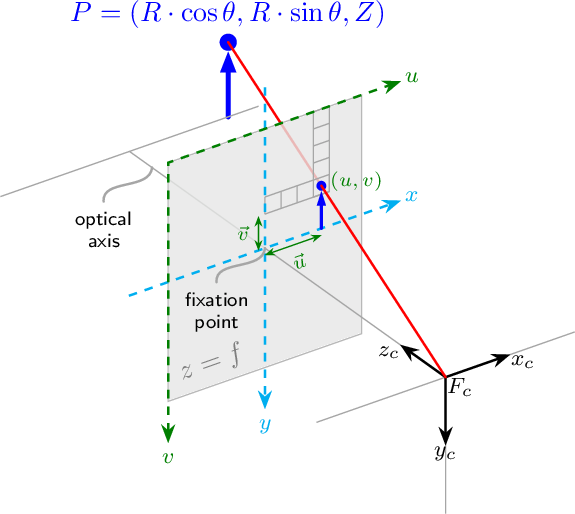

In [8]:
from IPython.display import Image
Image('../files/2025-04-24-orienting-yourself-in-the-visual-flow.png')

In that coordinates $u$ and $v$ are respectively the azimuth and elevation of the pixel.


Let's first define a first grid as a set of points defined with a focal plane at $f$ such that coordinates are between $-VA/2$ and $VA/2$ where $VA$ is the visual angle. Let's define the corresponding meshgrid:

In [9]:
image_size_az, image_size_el = 360, 360

VA = torch.pi/4

az = torch.linspace(-VA/2, VA/2, image_size_az)
el = torch.linspace(-VA/2, VA/2, image_size_el)

# Create a meshgrid
grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')
grid_az.shape, grid_el.shape

(torch.Size([360, 360]), torch.Size([360, 360]))

On the first axis, the relative angle $\theta$ of the pixel is such that $ \theta = \arctan\frac v u$.

For the second axis, we need to estimate the depth of each pixel on the surface of the cylinder. Knowing its radius $R$, the deviation $\phi$ of the pixel with respect to the axis is such that $\tan \phi = \frac R Z$. This is different but similar in principle to the modulation of spatial frequency with eccentricity of Kelly's "Retinal Inhomogeneity. III. Circular-Retina Theory" (1985).

In all generality that angle is defined as the Great-circle distance to transform the azimuth and elevation into a deviation angle from the gaze axis:

In [10]:
# see https://github.com/NaturalPatterns/2013_Tropique/blob/master/modele_dynamique.py#L20
def arcdistance(rae1, rae2):
    """
    Returns the angle on the great circle (in radians)

    # rae1 ---> rae2

    r = distance from the center of spherical coordinates (meters)
    a = azimuth = declination = longitude (radians)
    e = elevation = right ascension = latitude (radians)

    http://en.wikipedia.org/wiki/Great-circle_distance
    http://en.wikipedia.org/wiki/Vincenty%27s_formulae

    """
    a = (torch.cos(rae2[2, ...]) * torch.sin(rae2[1, ...] - rae1[1, ...]))**2
    a += (torch.cos(rae1[2, ...]) * torch.sin(rae2[2, ...]) - torch.sin(rae1[2, ...]) * torch.cos(rae2[2, ...]) * torch.cos(rae2[1, ...] - rae1[1, ...]))**2
    b = torch.sin(rae1[2, ...]) * torch.sin(rae2[2, ...]) + torch.cos(rae1[2, ...]) * torch.cos(rae2[2, ...]) * torch.cos(rae2[1, ...] - rae1[1, ...])

    return torch.arctan2(torch.sqrt(a), b)

It's fine in that range of angles to use instead the approximation that
$\phi = \sqrt{u^2 + v^2}$. Such that the depth corresponding to that pixel is given by $\frac{R}{\tan \phi}$. Since we repeat the texture at a period of $P$ we may take the remainder to target the appropriate part in the texture. Notice that the cylinder may be scaled in $P$ and $R$ with the same visual result. To remove one constrained parameter, we will set $R=1$ in arbitrary units.

These equations may be formulated as a vectorial computation :

In [11]:
P = 10. # period for the mapped image

grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1

grid_theta.shape, grid_depth.shape

(torch.Size([360, 360]), torch.Size([360, 360]))

These are then formated in the right format (see `help(.grid_sample)` for more enlightments) to be used by the function:

In [12]:
tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim
tunnel_grid.shape

torch.Size([1, 360, 360, 2])

In [13]:
tunnel_grid.min(),tunnel_grid.max()

(tensor(-1.000), tensor(1.000))

In [14]:
# F.grid_sample?

### application to a synthetic image

We define a synthetic image to illustrate the transform, it consists of white pixels, red verticals and blue horizontals, regularly spaced plus some boxes colored in hommage to Italy for visual inspection of the results:

In [15]:
image_size_grid = 257
image_size_grid = 513
image_grid_size = 32
image_grid_tens = torch.ones((3, image_size_grid, image_size_grid)).float()
image_grid_tens[0:2, ::image_grid_size, :] = 0
image_grid_tens[1:3, :, ::image_grid_size] = 0
fovea_size = 3
image_grid_tens[[0, 2], 
                image_size_grid//2:, 
                :image_size_grid//2, 
                ] = 0
image_grid_tens[[1, 2], 
                :image_size_grid//2, 
                image_size_grid//2:, 
                ] = 0
image_grid_tens[:, (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size), (image_size_grid//2-image_grid_size*fovea_size):(image_size_grid//2+image_grid_size*fovea_size)] *= .5
image_grid_tens.shape, image_grid_tens.unsqueeze(0).shape

(torch.Size([3, 513, 513]), torch.Size([1, 3, 513, 513]))

to display it, we need to transform the torch format to a numpy / matplotlib compatible one, which can be first tested on a MWE (minimal working example) using `torch.movedim`:

In [16]:
torch.movedim(torch.randn(1, 2, 3), (0, 1, 2), (1, 2, 0)).shape

torch.Size([3, 1, 2])

this can be done on the image in a few lines:

In [17]:
image_grid = image_grid_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid = torch.movedim(image_grid, (1, 2, 0), (0, 1, 2))
image_grid = image_grid.numpy()
image_grid.shape

(513, 513, 3)

so that we can display the synthetic image:

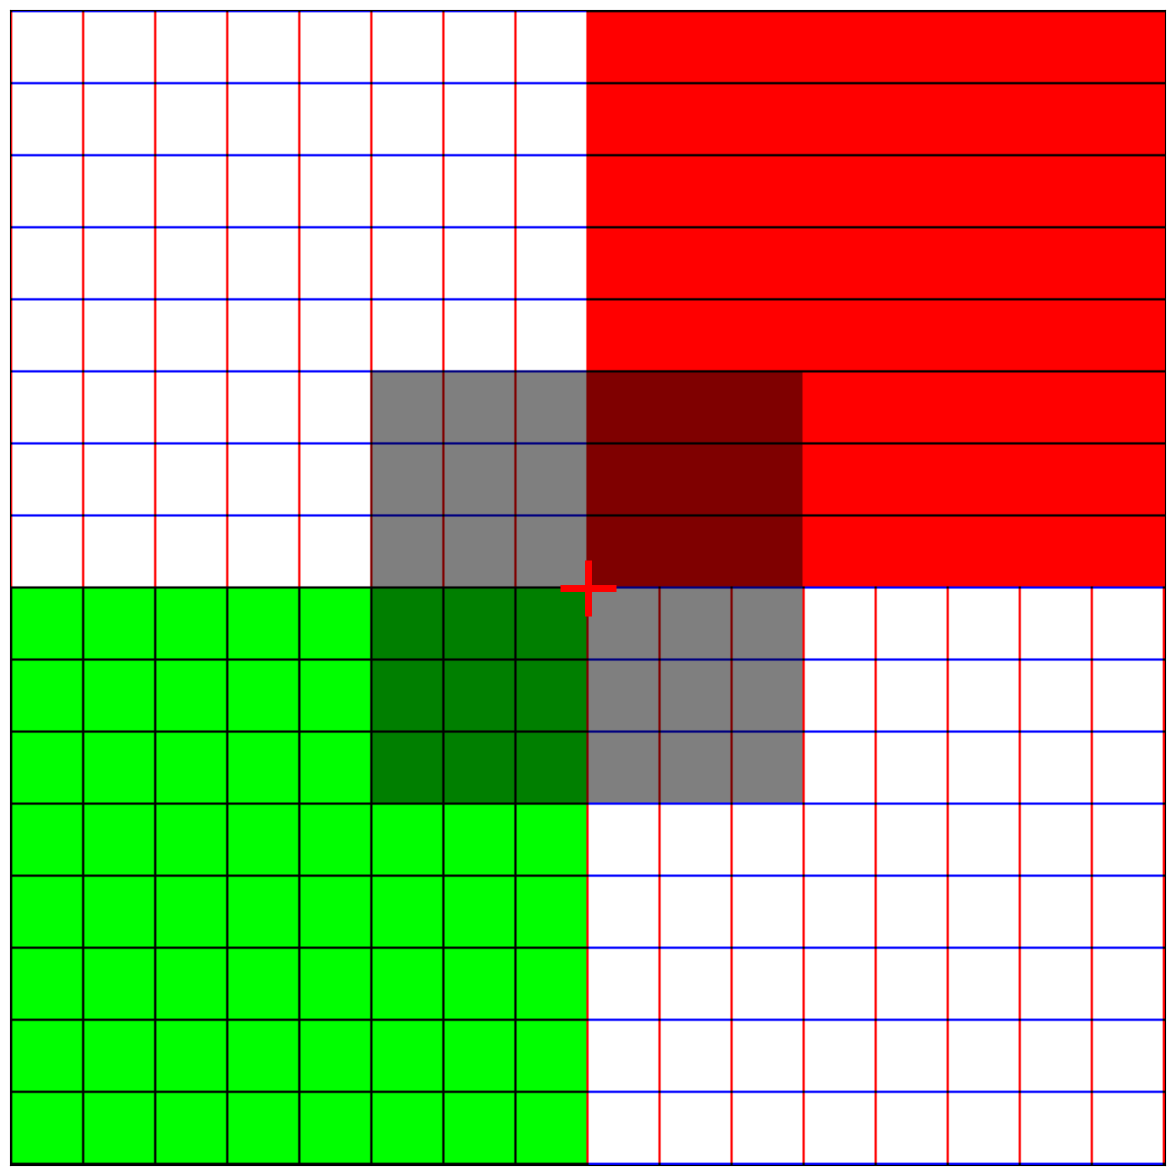

In [18]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid)
ax.plot(image_size_grid//2, image_size_grid//2, 'r+', markersize=40, markeredgewidth=5)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Let's transform the image of the grid:

In [19]:
image_grid_tunnel_tens = F.grid_sample(image_grid_tens.unsqueeze(0).float(), tunnel_grid, 
                                    mode='bilinear', align_corners=False, padding_mode='border')
image_grid_tens.shape, tunnel_grid.shape, image_grid_tunnel_tens.shape

(torch.Size([3, 513, 513]),
 torch.Size([1, 360, 360, 2]),
 torch.Size([1, 3, 360, 360]))

and transform it back to numpy:

In [20]:
image_grid_tunnel_tens = image_grid_tunnel_tens.squeeze(0)
# swap from C, H, W (torch) to H, W, C (numpy)
image_grid_tunnel_tens = torch.movedim(image_grid_tunnel_tens, (1, 2, 0), (0, 1, 2))
image_grid_tunnel = image_grid_tunnel_tens.numpy()
image_grid_tunnel /= image_grid_tunnel.max()
image_grid_tunnel.shape

(360, 360, 3)

to then display the retinotopic transform of the grid image:

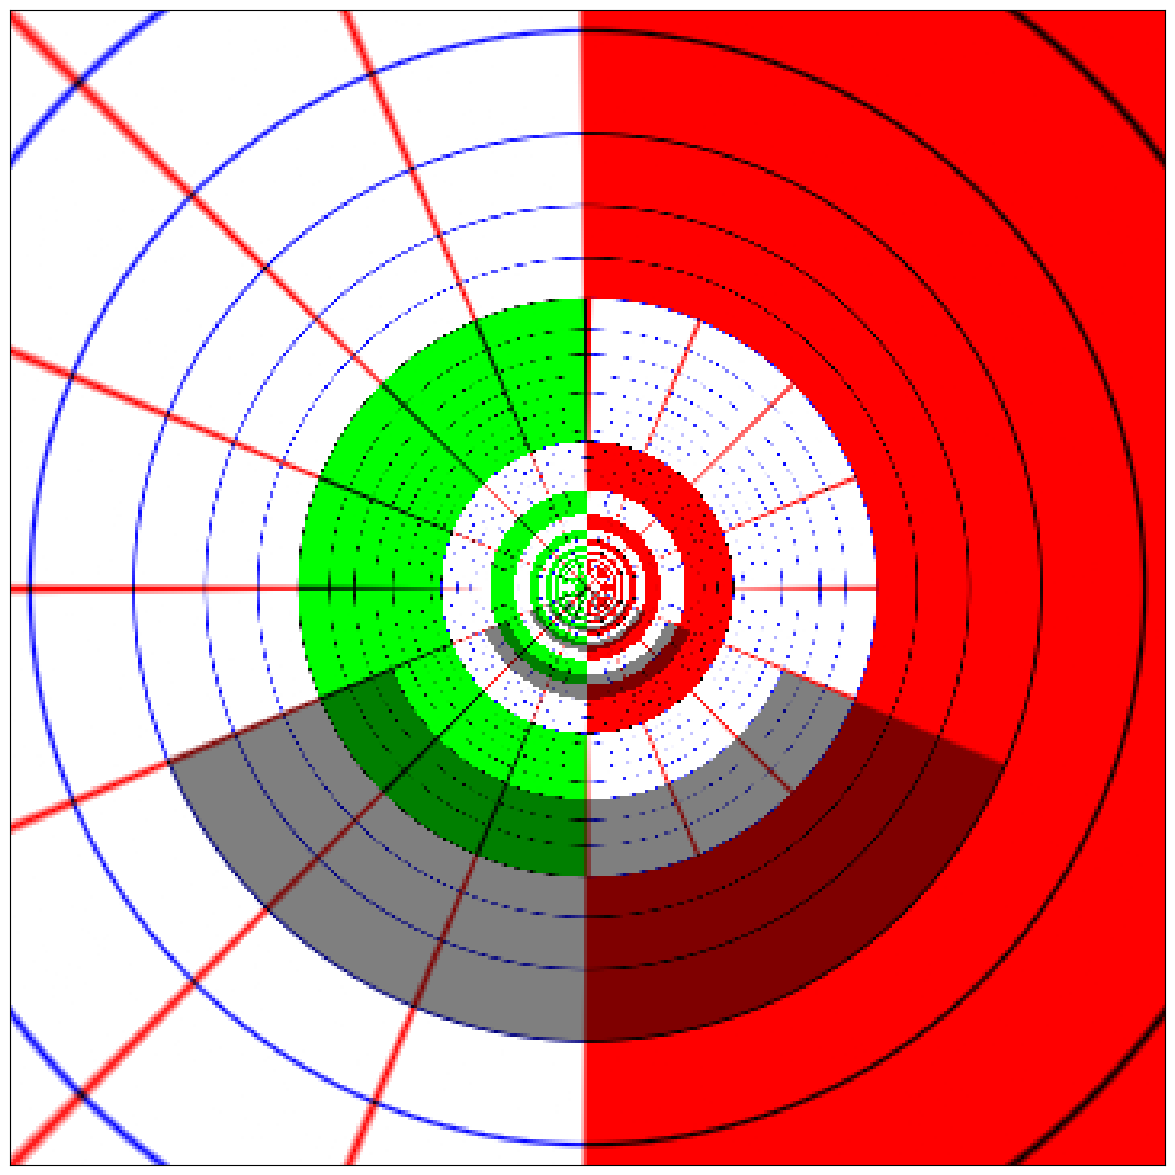

In [21]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid_tunnel)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

In [22]:
image_grid_tunnel.min(), image_grid_tunnel.max(), image_grid_tunnel.mean(), image_grid_tunnel.std()

(np.float32(0.0),
 np.float32(1.0),
 np.float32(0.5908904),
 np.float32(0.4580183))

To avoid border effects, we will add a circular mask. Additionally, a natural depth effect is that luminance decreases in inverse proportion to distance (see for instance https://laurentperrinet.github.io/sciblog/posts/2021-03-27-density-of-stars-on-the-surface-of-the-sky.html) :

In [23]:
image_grid_tunnel = image_grid_tunnel * grid_mask[:, :, None]
image_grid_tunnel = image_grid_tunnel / grid_depth.numpy()[:, :, None]
image_grid_tunnel /= image_grid_tunnel.max()

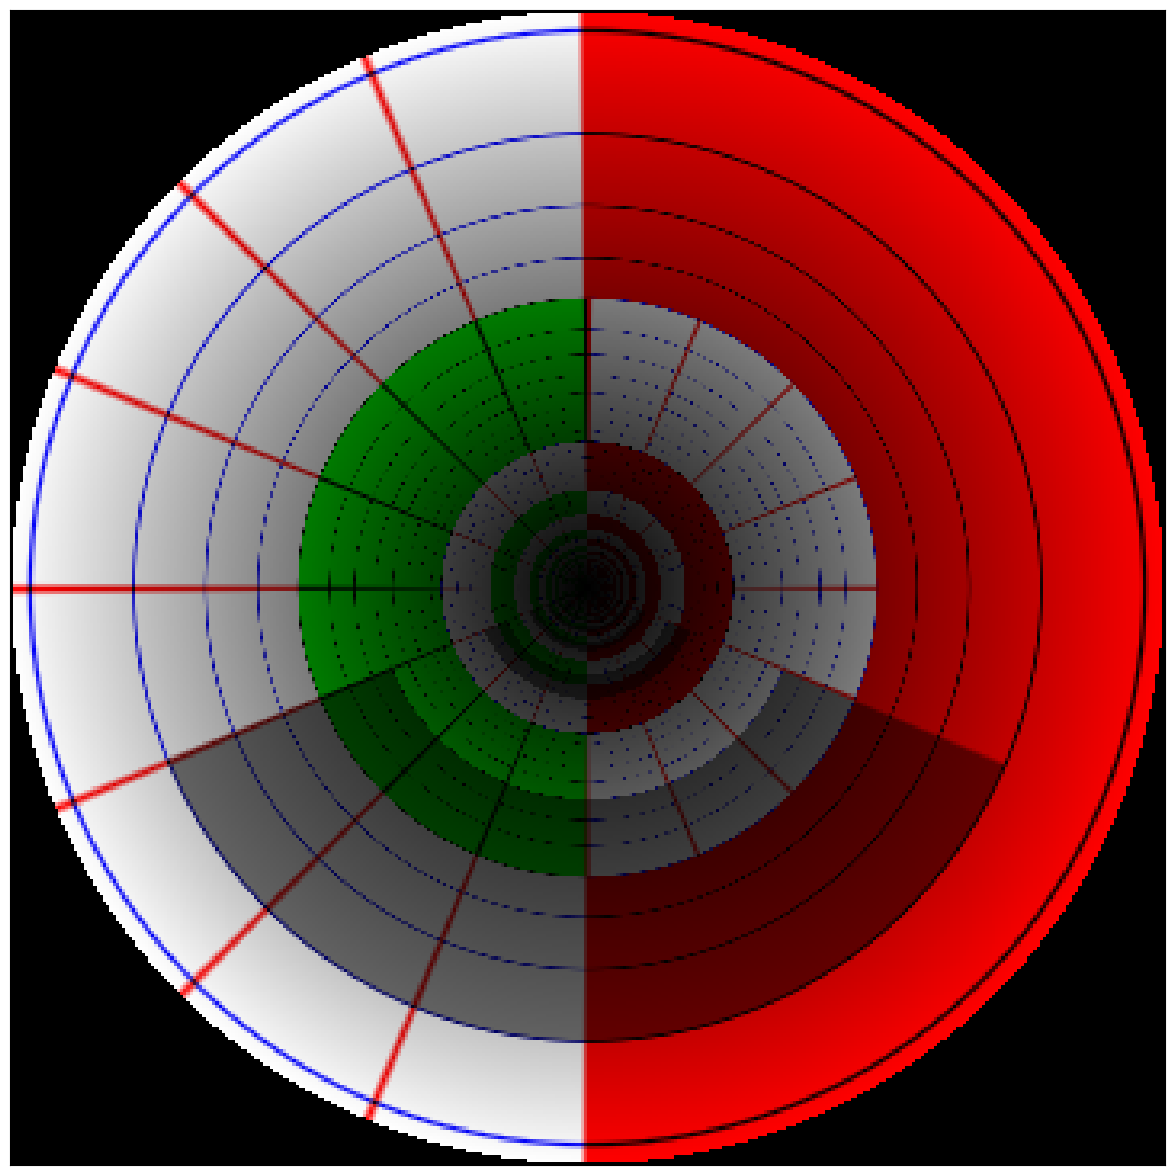

In [24]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_grid_tunnel)
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

Not bad. Things are all on place.

### Application to a texture

As a generic visual texture, let's synthetize a static motionclouds (see https://laurentperrinet.github.io/sciblog/posts/2016-07-14_static-motion-clouds.html):

In [25]:
# %pip install MotionClouds

In [26]:
import MotionClouds as mc
fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
image.min(), image.max(), image.mean(), image.std(), image.shape

(np.float64(0.0),
 np.float64(0.9830263878546276),
 np.float64(0.5),
 np.float64(0.115358022939608),
 (360, 360, 1))

and display it:

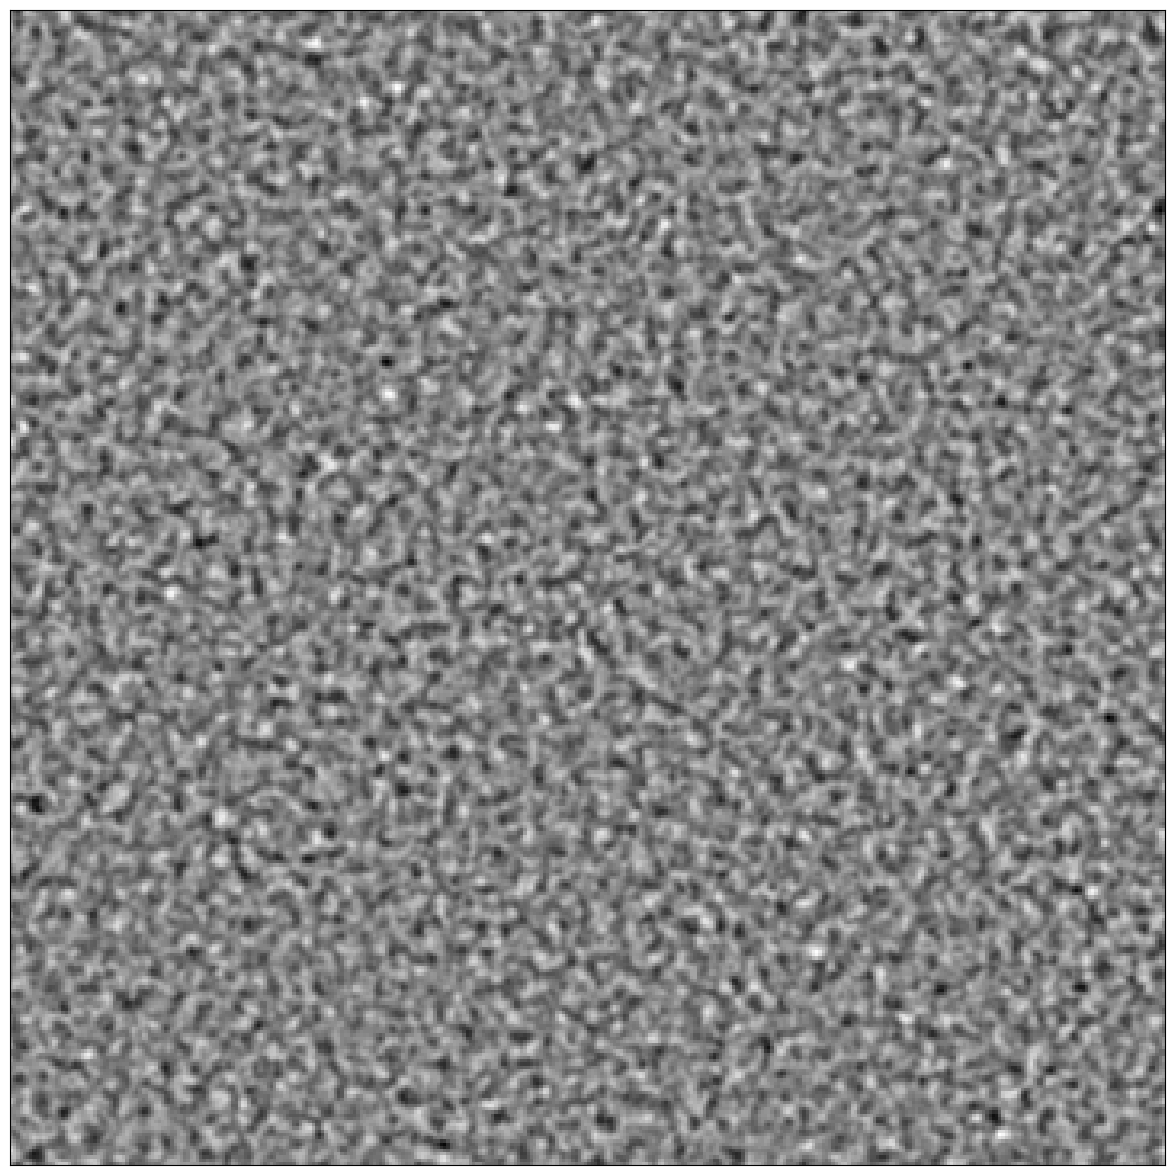

In [27]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

to use it in the function, we need to transform the numpy format to a torch compatible one, which can be first tested on a MWE (minimal working example):

In [28]:
torch.movedim(torch.randn(1, 2, 3), (1, 2, 0), (0, 1, 2)).shape

torch.Size([2, 3, 1])

this now looks like:

In [29]:
image_tens = torch.from_numpy(image)
# swap from H, W, C (numpy) to C, H, W (torch)
image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))
image.shape, image_tens.shape

((360, 360, 1), torch.Size([1, 360, 360]))

Let's transform the image:

In [30]:
image_tunnel_tens = F.grid_sample(image_tens.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
image_tunnel_tens.shape

torch.Size([1, 1, 360, 360])

and transform it back to numpy:

In [31]:
image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
image_tunnel = image_tunnel_tens.numpy()
image_tunnel.shape

(360, 360)

In [32]:
image_tunnel = image_tunnel * grid_mask
image_tunnel = image_tunnel / grid_depth.numpy()
image_tunnel /= image_tunnel.max()
image_tunnel.shape

(360, 360)

and display it:

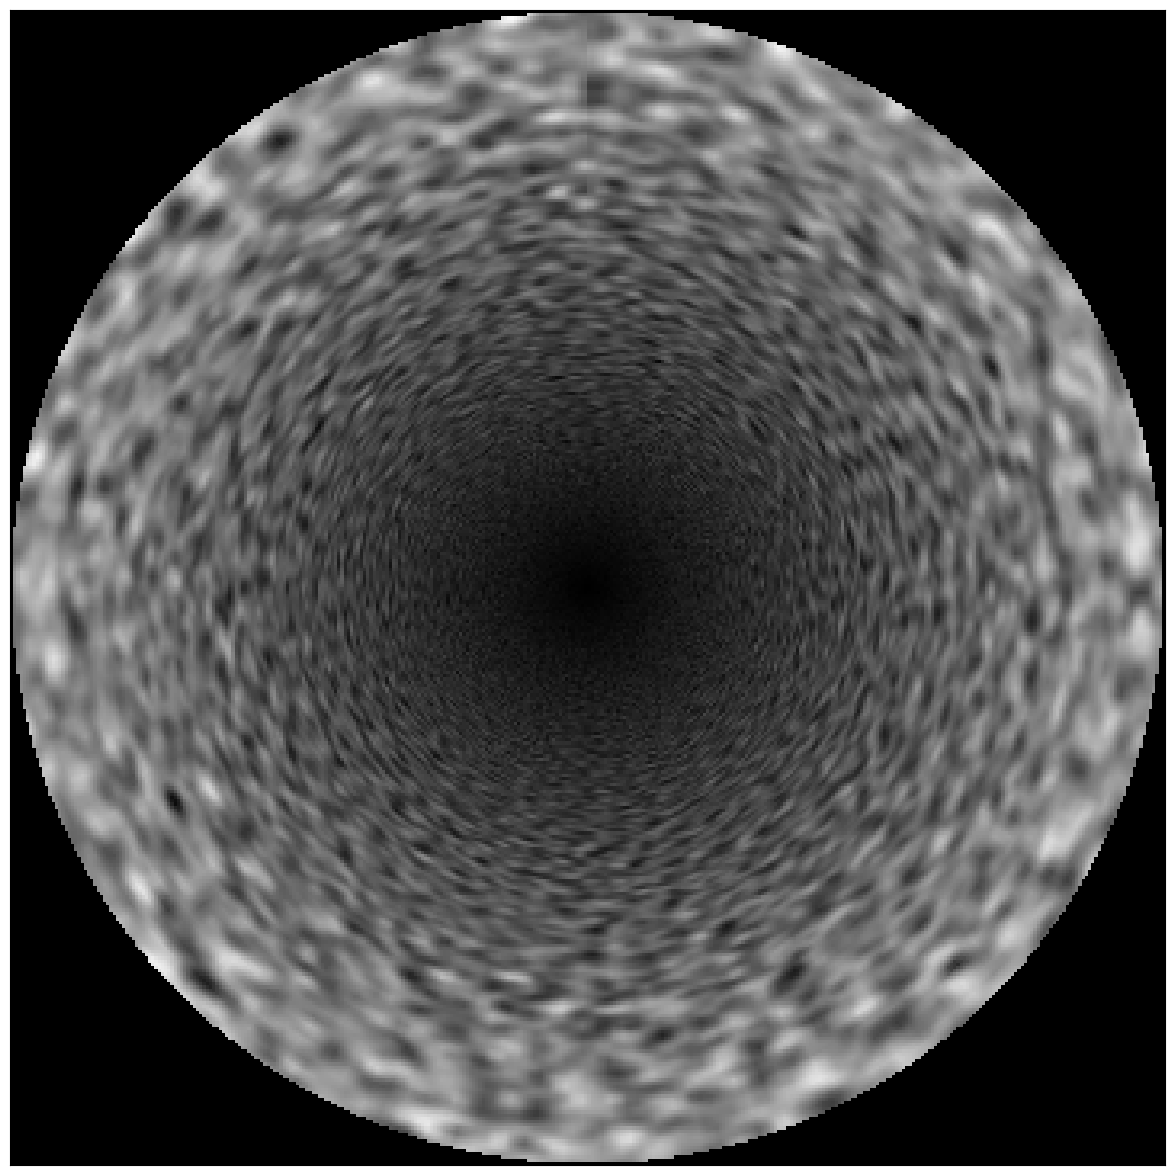

In [33]:
fig, ax = plt.subplots(figsize=(fig_width, fig_width))
ax.imshow(image_tunnel, cmap='gray')
ax.set_xticks([])
ax.set_yticks([])  
fig.set_facecolor(color='white')

We mapped a texture to the cylinder and we may simulate motion by moving the texture. One feature of static Motion Clouds is their periodicity, such that there will be no border effects when "rolling" the image progressively.

### wrapping up and make a movie


Now that we have all elements, let's wrap them up in a single function and export the result as a

In [34]:
# %pip install imageio[ffmpeg]

import imageio
def make_mp4(moviename, fnames, fps):
    # Create a video writer object
    writer = imageio.get_writer(moviename, fps=fps)  # Adjust the fps as needed

    # Write frames to the video
    for fname in fnames:
        img = imageio.v2.imread(fname)
        writer.append_data(img)

    # Close the writer
    writer.close()
    return moviename


In [35]:
import matplotlib

UPSCALE = 2
image_size_az, image_size_el = 368*UPSCALE, 368*UPSCALE

def make_shots(figname, 
               image_size_az=image_size_az, image_size_el=image_size_el, 
               VA = torch.pi/4,
               P = 10., # period for the mapped image
               cache_path='/tmp',
               do_mask=True,
               do_distance=True,
               fps = 60 # frames per second
    ):

    az = torch.linspace(-VA/2, VA/2, image_size_az)
    el = torch.linspace(-VA/2, VA/2, image_size_el)

    # Create a meshgrid
    grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')

    grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
    grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
    grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
    grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1


    tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
    tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim

    fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
    image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
    image_tens = torch.from_numpy(image)
    # swap from H, W, C (numpy) to C, H, W (torch)
    image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))


    fnames = []
    figname_ = figname.split('/')[-1]

    for t in range(image_size_az):
        fname = f'{cache_path}/{figname_}_{t}.png'

        image_tens_ = torch.roll(image_tens, shifts=-t, dims=1)

        image_tunnel_tens = F.grid_sample(image_tens_.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
        image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
        image_tunnel = image_tunnel_tens.numpy()
        if do_mask: image_tunnel = image_tunnel * grid_mask
        if do_distance:
            image_tunnel = image_tunnel / grid_depth.numpy()
            image_tunnel /= image_tunnel.max()

        imageio.imwrite(fname, (image_tunnel * 255).astype(np.uint8), format='png')

        fnames.append(fname)

    make_mp4(figname, fnames, fps=fps)
    for fname in fnames: os.remove(fname)    
    return figname # returns filename


In [36]:
figname = os.path.join('..', 'files', '2025-04-24-orienting-yourself-in-the-visual-flow.mp4')

In [37]:
if not os.path.isfile(figname): 
    figname = make_shots(figname)


### Adding a perturbation

We made an optimal motion which goes smoothly along the cylinder's axis. Boring, right? Let's now do a simple pinch and visually check if one can follow our perturbation to the FoE:


In [38]:

def make_shots_perturb(figname, 
               image_size_az=image_size_az, image_size_el=image_size_el, 
               VA = torch.pi/4,
               P = 10., # period for the mapped image
               margin=image_size_az//8,
               cache_path='/tmp',
               do_mask=True,
               do_distance=True,
               fps = 60 # frames per second
    ):

    az = torch.linspace(-VA/2, VA/2, image_size_az+2*margin)
    el = torch.linspace(-VA/2, VA/2, image_size_el+2*margin)

    # Create a meshgrid
    grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')

    grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
    grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
    grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
    grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1


    tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
    tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim

    fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
    image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
    image_tens = torch.from_numpy(image)
    # swap from H, W, C (numpy) to C, H, W (torch)
    image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))

    fnames = []
    figname_ = figname.split('/')[-1]

    for t in range(image_size_az):
        fname = f'{cache_path}/{figname_}_{t}.png'

        image_tens_ = torch.roll(image_tens, shifts=-t, dims=1)

        image_tunnel_tens = F.grid_sample(image_tens_.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
        image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
        image_tunnel = image_tunnel_tens.numpy()
        if do_distance:
            image_tunnel = image_tunnel / grid_depth.numpy()
            image_tunnel /= image_tunnel.max()

        if np.cos(2*torch.pi*t/image_size_az) < 0:
            az_perturb = margin * np.sin(4*torch.pi*t/image_size_az)
            image_tunnel = np.roll(image_tunnel, shift=az_perturb, axis=1)

        image_tunnel = image_tunnel[margin:-margin, margin:-margin]
        # if do_mask: image_tunnel = image_tunnel * grid_mask # to FIX 
        imageio.imwrite(fname, (image_tunnel * 255).astype(np.uint8), format='png')

        fnames.append(fname)

    make_mp4(figname, fnames, fps=fps)
    for fname in fnames: os.remove(fname)    
    return figname # returns filename

In [39]:
figname = os.path.join('..', 'files', '2025-04-24-orienting-yourself-in-the-visual-flow-perturb.mp4')
# %rm {figname}

In [40]:
if not os.path.isfile(figname): 
    figname = make_shots_perturb(figname)


### Adding two lines to create Hering's illusion

One explanation of [Hering's illusion](https://en.wikipedia.org/wiki/Hering_illusion) is that the perceived bending effect may be driven by the perspective induced by the converging lines. 

Is the optic flow enough to produce the same effect? 



In [41]:
def make_shots_hering(figname, 
               image_size_az=image_size_az, image_size_el=image_size_el, 
               VA = torch.pi/4,
               P = 40., # period for the mapped image
               line_radius=image_size_az//8,
               line_width=image_size_az//128,
               n_frames=image_size_az//4,
               cache_path='/tmp',
               do_mask=False,
               do_distance=True,
               fps = 60 # frames per second
    ):

    az = torch.linspace(-VA/2, VA/2, image_size_az)
    el = torch.linspace(-VA/2, VA/2, image_size_el)

    # Create a meshgrid
    grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')

    grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
    grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
    grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
    grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1


    tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
    tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim

    fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
    image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
    image_tens = torch.from_numpy(image)
    # swap from H, W, C (numpy) to C, H, W (torch)
    image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))


    fnames = []
    figname_ = figname.split('/')[-1]

    for t in range(2*n_frames):
        fname = f'{cache_path}/{figname_}_{t}.png'

        image_tens_ = torch.roll(image_tens, shifts=-min(t, 2*n_frames-t), dims=1) # back and reverse

        image_tunnel_tens = F.grid_sample(image_tens_.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
        image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
        image_tunnel = image_tunnel_tens.numpy()
        if do_mask: image_tunnel = image_tunnel * grid_mask
        if do_distance:
            image_tunnel = image_tunnel / grid_depth.numpy()
            image_tunnel /= image_tunnel.max()

        image_tunnel = image_tunnel[:, :, None] * np.ones((1, 1, 3)) # going RGB

        image_tunnel[(image_size_az//2-line_radius-line_width//2):(image_size_az//2-line_radius+line_width//2), :, :] = 0
        image_tunnel[(image_size_az//2-line_radius-line_width//2):(image_size_az//2-line_radius+line_width//2), :, 0] = 1
        image_tunnel[(image_size_az//2+line_radius-line_width//2):(image_size_az//2+line_radius+line_width//2), :, :] = 0
        image_tunnel[(image_size_az//2+line_radius-line_width//2):(image_size_az//2+line_radius+line_width//2), :, 0] = 1

        imageio.imwrite(fname, (image_tunnel * 255).astype(np.uint8), format='png')

        fnames.append(fname)

    make_mp4(figname, fnames, fps=fps)
    for fname in fnames: os.remove(fname)    
    return figname # returns filename

In [42]:
figname = os.path.join('..', 'files', '2025-04-24-orienting-yourself-in-the-visual-flow-hering.mp4')

In [43]:
if not os.path.isfile(figname): 
    figname = make_shots_hering(figname)

In [44]:
Video(figname, html_attributes=html_attributes)


### Is the same percevied afer a Motion After-Effect?

Let's generate an optic flow long enough to generate a Motion After-Effect (MAE) and then present the two horizontal lines... Does this produce the same effect? 



In [45]:
def make_shots_hering_MAE(figname, 
               image_size_az=image_size_az, image_size_el=image_size_el, 
               VA = torch.pi/4,
               P = 40., # period for the mapped image
               line_radius=image_size_az//12,
               line_width=image_size_az//128,
               n_frames=image_size_az,
               ratio_MAE=0.95, # ratio of frames for the MAE
               cache_path='/tmp',
               do_mask=False,
               do_distance=True,
               fps = 60 # frames per second
    ):

    az = torch.linspace(-VA/2, VA/2, image_size_az)
    el = torch.linspace(-VA/2, VA/2, image_size_el)

    # Create a meshgrid
    grid_az, grid_el = torch.meshgrid(az, el, indexing='ij')

    grid_theta = torch.arctan2(grid_el, grid_az) / (torch.pi)
    grid_mask = (torch.sqrt(grid_az**2+grid_el**2) < VA / 2).float().numpy()
    grid_depth = 1/torch.tan(torch.sqrt(grid_az**2+grid_el**2))
    grid_depth_mod = 2 * torch.remainder(grid_depth, P) / P -1


    tunnel_grid = torch.stack((grid_theta, grid_depth_mod), 2)
    tunnel_grid = tunnel_grid.unsqueeze(0) # add batch dim

    fx, fy, ft = mc.get_grids(image_size_az, image_size_el, 1)
    image = mc.rectif(mc.random_cloud(mc.envelope_gabor(fx, fy, ft, B_theta=np.inf)))
    image_tens = torch.from_numpy(image)
    # swap from H, W, C (numpy) to C, H, W (torch)
    image_tens = torch.movedim(image_tens, (0, 1, 2), (1, 2, 0))


    fnames = []
    figname_ = figname.split('/')[-1]

    for t in range(n_frames):
        fname = f'{cache_path}/{figname_}_{t}.png'

        if t < int(n_frames*ratio_MAE):
            image_tens_ = torch.roll(image_tens, shifts=-t, dims=1) # back and reverse

            image_tunnel_tens = F.grid_sample(image_tens_.unsqueeze(0).float(), tunnel_grid, align_corners=False, padding_mode='border')
            image_tunnel_tens = image_tunnel_tens.squeeze(0).squeeze(0)
            image_tunnel = image_tunnel_tens.numpy()
            if do_mask: image_tunnel = image_tunnel * grid_mask
            if do_distance:
                image_tunnel = image_tunnel / grid_depth.numpy()
                image_tunnel /= image_tunnel.max()

            image_tunnel = image_tunnel[:, :, None] * np.ones((1, 1, 3)) # going RGB

        else:
            image_tunnel = np.zeros((image_size_az, image_size_az, 3), dtype=np.float32)

            image_tunnel[(image_size_az//2-line_radius-line_width//2):(image_size_az//2-line_radius+line_width//2), :, :] = 0
            image_tunnel[(image_size_az//2-line_radius-line_width//2):(image_size_az//2-line_radius+line_width//2), :, 0] = 1
            image_tunnel[(image_size_az//2+line_radius-line_width//2):(image_size_az//2+line_radius+line_width//2), :, :] = 0
            image_tunnel[(image_size_az//2+line_radius-line_width//2):(image_size_az//2+line_radius+line_width//2), :, 0] = 1

        imageio.imwrite(fname, (image_tunnel * 255).astype(np.uint8), format='png')

        fnames.append(fname)

    make_mp4(figname, fnames, fps=fps)
    for fname in fnames: os.remove(fname)    
    return figname # returns filename

In [46]:
figname = os.path.join('..', 'files', '2025-04-24-orienting-yourself-in-the-visual-flow-hering-MAE.mp4')
# %rm {figname} # HACK

In [47]:
Video(figname, html_attributes=html_attributes)

In [48]:
if not os.path.isfile(figname): 
    figname = make_shots_hering_MAE(figname)

I do not perceive any effect of the motion on the position of the lines. And you?

## some book keeping for the notebook

In [49]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,matplotlib,imageio  -r -g -b

Python implementation: CPython
Python version       : 3.13.7
IPython version      : 8.30.0

numpy     : 2.2.4
matplotlib: 3.10.1
imageio   : 2.37.0

Compiler    : Clang 17.0.0 (clang-1700.0.13.3)
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

Hostname: obiwan.local

Git hash: e48534ce6e9721431a3338d8675dde8c7ea8db2b

Git repo: https://github.com/laurentperrinet/sciblog

Git branch: master

